# 🔎 Retrieval (and QG?) playground

In [3]:
import json, random
import matplotlib.pyplot as plt
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
from sentence_transformers import CrossEncoder
from langchain_community.vectorstores import FAISS
from tqdm.notebook import tqdm
from langchain_community.retrievers import BM25Retriever

embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")


## ⚙️ 0. Choose claim & docstore

In [2]:
random.seed(111)

In [3]:
random.randint(0, 500)


423

In [4]:
CLAIM_ID = 252
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))

# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China. [Refuted]

**https://www.nytimes.com/2019/11/26/arts/music/judy-collins.html**

 * 

**https://azsos.gov/elections/campaign-finance/financial-disclosure-statements/2022-financial-disclosure-statements**

 * 

**https://www.wsj.com/articles/employees-ask-facebook-to-reverse-policy-on-political-ad-fact-checking-11572311436**

 * 

### 🗂️ 0.1 Docstore formatting/scraping

In [4]:
for CLAIM_ID in tqdm(range(500)):# Naive version with \n concatenated url2texts:   
    datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
    claim = datapoint["claim"]
    display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
    docstore = []
    for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
        docstore.append(json.loads(line))
        
    documents = [
        Document(
            page_content=" ".join(doc["url2text"]),
            metadata={
                "url": doc["url"],
                # "sentences": doc["url2text"]
            },
        )
        for doc in docstore
    ]

    TOKENS_PER_CHAR = 0.25
    EMBEDDING_INPUT_SIZE = 512

    chunks = []
    for doc in docstore:
        buffer = ""
        for i, sentence in enumerate(doc["url2text"]):
            if (
                i == len(doc["url2text"]) - 1
                or len(buffer) + len(sentence) >= EMBEDDING_INPUT_SIZE / TOKENS_PER_CHAR
            ):
                context_before = ""
                if chunks and chunks[-1].metadata["url"] == doc["url"]:
                    chunks[-1].metadata["context_after"] = buffer
                    context_before = chunks[-1].page_content
                chunks.append(
                    Document(
                        page_content=buffer,
                        metadata={"url": doc["url"], "context_before": context_before, "context_after": ""},
                    )
                )

                buffer = ""
            buffer += sentence + " "
    # chunk the documents into smaller pieces
    chid = random.randint(0, len(chunks))

    display(Markdown(chunks[chid].metadata["context_before"]))
    display(Markdown(chunks[chid].page_content))
    display(Markdown(chunks[chid].metadata["context_after"]))
    
    retriever = BM25Retriever.from_documents(
        chunks, k=1500
    )
    chunks_pruned = retriever.invoke(claim)
    db = FAISS.from_documents(chunks_pruned, embeddings)
    db.save_local(f"data_store/vector_store_dev/{CLAIM_ID}")
    
                          

  0%|          | 0/500 [00:00<?, ?it/s]

### 🗯️ In a letter to Steve Jobs, Sean Connery refused to appear in an apple commercial. [Refuted]

As these (and many similar) examples show, creative ideas often come at a time when the person appears to be thinking about something else, Archimedes was lazing in his bath, and Poincaré was looking forward to his sight-seeing trip. Kekulé was half asleep by the ﬁre, and Hadamard was fast asleep in bed (until suddenly awakened). Marcel Proust was engaged in the most trivial of pursuits – eating a cake – when he was overcome by the recollections which led him to write his great novel. And Samuel Taylor Coleridge’s poetic vision of Xanadu came to him in an opium-induced reverie. In this case, the new ideas were ﬂeeting, and easily lost through distraction. The haunting imagery of Kubla Khan, with its breathtaking mixture of sweetness and savagery, would have been even richer if the ‘person on business from Porlock’ had not knocked on    point of view, intuition is an enigma. Some- times, it is experienced as a sudden ﬂash of insight, with no immedi- ately preceding ideas in consciousness. Hadamard is a case in point: ‘On being very abruptly awakened by an external noise, a solution long searched for appeared to me at once without the slightest instant of Other times, a little more can be said. For instance, here is Kekulé’s account of how, in 1865, he arrived at his insight about benzene: I turned my chair to the ﬁre and dozed. Again the atoms were gambolling before my eyes. This time the smaller groups kept modestly in the background. My mental eye, rendered more acute by repeated visions of this kind, could now dis- tinguish larger structures, of manifold conformation; long rows, sometimes more closely ﬁtted together; all twining and twisting in snakelike motion. But look! What was that? One of the snakes had seized hold of its own tail, and the form whirled mockingly before my eyes. As if by a ﬂash of light- This famous ﬁreside vision, which initiated the notion of the benzene molecule shown in Figure 2.1, will be discussed in detail in Chapter 4. 

Here, let us merely note that it was not an isolated incident. Kekulé had had similar experiences before (hence his reference to ‘repeated visions One of these had occurred almost a decade earlier. At that time, Kekulé was puzzling over how to describe the detailed internal structure One ﬁne summer evening, I was returning by the last omnibus [buses again!], ‘outside’ as usual, through the deserted streets of the metropolis, which are at other times so full of life. I fell into a reverie, and lo! the atoms were gambolling before my eyes. Whenever, hitherto, these diminutive beings had appeared to me, they had always been in motion; but up to that time, I had never been able to discern the nature of their motion. Now, however, I saw how, frequently, two smaller atoms united to form a pair; how a larger one embraced two smaller ones; how still larger ones kept hold of three or even four of the smaller; whilst the whole kept whirling in a giddy dance. I saw how the larger ones formed a chain . . . I spent part of the night putting on paper at least sketches of these Partly as a result of this bus-borne reverie, Kekulé developed a new account of molecular structure, in which each individual atom could be located with respect to all the other constituent atoms. In so doing, he suggested that organic molecules were based on strings of carbon atoms. (This was independently suggested in the very same year, 1858, by the Scots chemist Alexander Couper: one of many historical examples of In his textbook of organic chemistry published in 1861, Kekulé rep- resented ethyl alcohol – written today as C2H5OH, or CH3CH2OH – by the diagram shown in Figure 2.2. As you can see, the ‘larger atoms’ of carbon are indeed ‘embracing’ the ‘smaller’ atoms. Two hydrogen atoms are joined as a ‘pair’. And the two carbon atoms are linked to form a Visual imagery, obviously, was important to Kekulé (who had been a student of architecture before turning to chemistry). It was important to 

Coleridge, too. But many reports of creativity mention no imagery. They simply recall the sudden appearance of the solution to a problem the individual had been working on with no apparent success. The suddenness of the solution is not its only strange feature. The answer to the prior question may be of an unexpected kind: Hadamard reports awaking with a solution ‘in a quite diﬀerent direction from any of those which I had previously tried to follow’. Sometimes, there appears to be no prior question – or, at least, no prior questioning. Picasso, for instance, implied that he formed no expectations, that he could advance his art without having to look where he was going: ‘Je ne cherche pas, je Picasso spoke, as ever, in the ﬁrst person. But others have disclaimed personal responsibility for the creation, or at least for signiﬁcant parts of it. For instance, the novelist William Golding denies having thought of the incident in The Lord of the Flies when the pig’s severed head speaks to the boy hiding in the bushes. He reports, instead, ‘I heard it’ – and remarks that at such moments ‘The author becomes a spectator,    to make of this? Although ‘sudden illumination’ may be a faithful description of how creativity appears to the creator, it cannot be the whole story. Intuition cannot consist merely in ﬂashes of Magic, or perhaps theology. We no longer accept Descartes’ seventeenth-century view that all human judgment is essentially unconstrained, that this intellectual freedom is the respect in which we are truly made in God’s image. We should be similarly sceptical of those twentieth-century ‘explanations’ which appeal to an unanalysed faculty of intuition or even (as cited in Chapter 1) to divine inspiration of the creative elite. We may sympathize with Einstein’s remark that Mozart was ‘only a guest on this earth’, or resonate to the concert-programme which declared: ‘Others may reach heaven with their works. But Mozart, he comes, he comes from there!’5 But while celebrating Mozart’s glory in 

### 🗯️ Trump Administration claimed songwriter Billie Eilish Is Destroying Our Country In Leaked Documents [Refuted]

The families now want a public inquiry into the bombing from Birmingham Julie Hambleton explains why they want this inquiry and the campaign to achieve it; they want justice, her sister Maxine died in the blast. Then in the Belfast studio DUP MP Ian Paisley Jnr and victim's campaigner Jude Whyte join the discussion, Paisley says the Birmingham families need a (MISSING) way to achieve justice, the PM needs to revisit his decision on no more public inquiries or find another mechanism for these families, even use the Northern Ireland HET in England. Then Jude Whyte condemns Birmingham bombs and the case of the Birmingham 6, he's not sure the HET would work, and explains why, that's a piecemeal approach, we need a DWP mechanism he says, he comments on a truth and reconciliation commission. Next Martina Purdy reports from North Antrim on the controversy over the environment minister Alex Attwood (SDLP) plans to create a national park. Film report with farmer Victor Chestnuts views. Then farmer Bernard McKay, then caravan park owner Olive Dunlop, then in Fermanagh UUP's Tom Elliott's gives his views then Green Part's Stephen Agnew. Then in the studio SDLP'S Environment Minister Alex Attwood's defends his plans and is questioned by Mark Carruthers. Next June the G8 summit will visit Fermanagh, film report reviews who is on the G8, and protest groups that follow them around then commentators F. O'Connor and Peter Shirlow comments on the topics discussed in the programme. |The protestant man Alan Lennon overlooked for a top post on the Water Board has been awarded £150,000 compensation for religious discrimination. Film report with Alan Lennon interview then Evelyn Collins of the Equality Commission's reaction, then Jamie Delargey analysis of this case and Sinn Fein Minister Conor Murphy's role in it. DUP's Peter Robinson says it will be 2016 before corporation tax is devolved to executive, he also comments on Alan Lennon case in interview and his relationship with Sinn Fein at present in a 5 party coalition. 

A community led inquiry into the loyalist murder of Catholic Gerard Lawlor in July 2002 has found failures in the PSNI investigation. Film report with John Lawlor's (comments), details of the report authors, Jane Winters British/Irish Human Rights Watch, comments then PSNI statement. North Belfast UVF DC Gary Hegarty has been granted bail as assisting offender film report on hearing; Hegarty is expected to testify against fellow UVF associates, and profile of charges. |Mark Carruthers begins with recalling the Birmingham pub bombs and death of 21 people, 38 years ago, for which 6 men were jailed but their convictions quashed in 1991. The families now want a public inquiry into the bombing, from Birmingham Julie Hambleton explains why they want this inquiry and the campaign to achieve it; they want justice, her sister Maxine died in the blast. Then in the Belfast studio DUP MP Ian Paisley Jnr and victim's campaigner Jude Whyte join the discussion, Paisley says the Birmingham families need a (MISSING) way to achieve justice, the PM needs to revisit his decision on no more public inquiries or find another mechanism for these families, even use the Northern Ireland HET in England. Then Jude Whyte condemns Birmingham bombs and the case of the Birmingham 6, he's not sure the HET would work, and explains why, that's a piecemeal approach, we need a DWP mechanism he says, he comments on a Truth and Reconciliation Commission. Next Martina Purdy reports from North Antrim on the controversy over the environment minister Alex Attwood (SDLP) plans to create a national park. Film report with farmer Victor Chestnuts views. Then farmer Bernard McKay, then caravan park owner Olive Dunlop, then in Fermanagh UUP's Tom Elliott's gives his views then Green Party's Stephen Agnew. Then in the studio SDLP'S Environment Minister Alex Attwood's defends his plans and is questioned by Mark Carruthers. 

Next June the G8 summit will visit Fermanagh, film report reviews who is on the G8, and protest groups that follow them around then commentators F. O'Connor and Peter Shirlow comments on the topics discussed in the programme. |Headlines then a row brews at Belfast City Hall over flying the Union flag every day. Film report in the studio Sinn Fein's Jim McVeigh and DUP's Chris Stalford views on the Sinn Fein motion about flag policy change, to designated days only. In North Belfast a suspicious object in Ardoyne has meant homes are evacuated. Court rules Gerard Delvin's families' human right broken when PPS didn't consult them on dropping murder charges to lesser charges. The Republics Agriculture Minister Simon Coveney TD is first Irish Minister to attend a DUP conference film report with interview, then DUP's Diane Dodd's comments. |Headlines then a row brews at Belfast City Hall over flying the Union flag every day. Film report in the studio Sinn Fein's Jim McVeigh and DUP's Chris Stalford views on the Sinn Fein motion about flag policy change, to designated days only. In North Belfast a suspicious object in Ardoyne has meant homes are evacuated. Court rules Gerard Delvin's families' human right broken when PPS didn't consult them on dropping murder charges to lesser charges. The Republics Agriculture Minister Simon Coveney TD is first Irish minister to attend a DUP conference film report with interview, then DUP's Diane Dodd's comments. |Report on Peter Robinson speech to the DUP conference, he rejects border poll idea saying Catholics and Protestants support the Union, he attacks Alliance party views on flag policies. In Derry two arrested in PSNI inquiry into dissident republican activity. In East Belfast shots fired at 26 year old man. |Live coverage of DUP leader Peter Robinson's speech to party delegates and highlights of other speeches begins with Mark Carruthers update on what's happened at the conference to date, with MEP Dianne Dodd's just finishing her address. 

### 🗯️ Due to Imran Khan's criticism of Macron's comments on Islam, French authorities cancelled the visas of 183 Pakistani citizens and deported 118 from the country. [Refuted]

invasion, resisted or unresisted, as a result of which the invader has rendered the invaded government incapable of publicly exercising its authority, and that the invader has successfully substituted its own authority for that of the legitimate government in the territory invaded.”). See also Armed Activities on the Territory of the Congo (Democratic Republic of the Congo v. Uganda), Judgment, 2005 I.C.J. 165, 230 (¶¶173-74) (“In order to reach a conclusion as to whether a State, the military forces of which are present on the territory of another State as a result of an intervention, is an ‘occupying Power’ in the meaning of the term as understood in jus in bello, the Court must examine whether there is sufficient evidence to demonstrate that the said authority was in fact established and exercised by the intervening State in the areas in question. In the present case the Court will need to satisfy itself that the Ugandan armed forces in the DRC were not only stationed in particular locations, but also that they had substituted their own authority for that of the Congolese Government … . [T]he territorial limits of any zone of occupation by Uganda in the DRC cannot be determined by simply drawing a line connecting the geographical locations where Ugandan troops were present as has been done on the sketch-map presented by the DRC (see 64 GREENSPAN, THE MODERN LAW OF LAND WARFARE 213-14 (“An occupant sets up some form of administration in the territory, an invader merely passing through it does not.”).  65 For example, MacLeod v. United States, 229 U.S. 416, 424-25 (1913) (“When the Spanish fleet was destroyed at Manila, May 1, 1898, it became apparent that the Government of the United States might be required to take the necessary steps to make provision for the government and control of such part of the Philippines as might come into the military occupation of the forces of the United States. The right to thus occupy an enemy’s country and 

temporarily provide for its government has been recognized by previous action of the executive authority and sanctioned by frequent decisions of this court. The local government being destroyed, the conqueror may set up its own authority and make rules and regulations for the conduct of temporary government, and to that end may collect taxes and duties to support the military authority and carry on operations incident to the occupation. course of the Government with respect to the territory acquired by conquest and afterwards ceded by the Mexican 66 Refer to § 11.8.2 (Continued Performance of Duties by Civil Servants and Other Officials of Local Governments). 67 Refer to § 11.2.4 (Proclamation of Occupation).  For example, the law of belligerent occupation would not apply to the use of military  forces to control a State’s own territory, such as in cases of domestic emergency, insurrection, or  Similarly, the law of belligerent occupation would not apply to the liberation of friendly  territory that was previously occupied by the enemy.70  The requirement of a hostile relationship between the invading force’s State and the State  of the occupied territory also prevents the law of belligerent occupation from applying to post- conflict situations (except for certain provisions of the GC).71    Scope of Occupied Territory.  The occupation extends only to the territory where  such authority has been established and can be exercised.72  For example, a State may remain in control of part of its territory while the remainder of  its territory is under occupation.  The 1949 Geneva Conventions apply in cases of partial or total  The end of occupation in one part of occupied territory does not end the occupation in  other parts of the occupied territory where the Occupying Power maintains its authority.  11.2.4 Proclamation of Occupation.  Due to the special relations established between the  civilian population of the occupied territory and the Occupying Power, the fact of military  

occupation and the territory over which it extends should be made known to the citizens of the  However, there is no specific legal requirement that the Occupying Power issue a  68 GWS art. 2 (“The Convention shall also apply to all cases of partial or total occupation of the territory of a High Contracting Party, even if the said occupation meets with no armed resistance.”); GWS-SEA art. 2 (same); GPW art. 69 Refer to § 11.1.3.3 (Occupation and Non-International Armed Conflict).  70 Refer to § 11.1.3.2 (Liberation of Friendly Territory).  71 Refer to § 11.1.3.4 (Occupation and Post-War Situations).  72 HAGUE IV REG. art. 42 (“Territory is considered occupied when it is actually placed under the authority of the hostile army. The occupation extends only to the territory where such authority has been established and can be 73 Refer to § 11.1.2.3 (Occupation and the 1949 Geneva Conventions).  74 1956 FM 27-10 (Change No. 1 1976) ¶357 (“In a strict legal sense no proclamation of military occupation is necessary. However, on account of the special relations established between the inhabitants of the occupied territory and the occupant by virtue of the presence of occupying forces, the fact of military occupation, with the extent of territory affected, should be made known. The practice of the United States is to make this fact known by proclamation.”); 1914 RULES OF LAND WARFARE ¶292 (“In a strict legal sense no proclamation of military occupation is necessary. On account of the special relations established between the inhabitants of the occupied The question of whether territory is occupied does not depend upon the issuance of any  particular proclamation or other instrument.  Territory may be occupied even though no  proclamation of occupation has been issued.  Conversely, the issuance of proclamation of  occupation does not empower a State with the rights of an Occupying Power if it does not  A proclamation may help fix the date of the beginning of the occupation.75  The  

### 🗯️ UNESCO declared Nadar community as the most ancient race in the world. [Refuted]

The Nadars today are a powerful community.[15] They are financially very strong and are also politically influential in the Southern Tirunelveli regions of Nanguneri, Srivaikuntam, Tiruchendur, Tuticorin and Kaniyakumari. There is a Nadar in almost every political party. The community also has influential Tamil media houses like Dina Thanthi in its fold.[16] Crawford Young, Professor Emeritus of Political Science at the University of Wisconsin–Madison, in his book The politics of cultural pluralism writes, Today, the Nadars are recognized as an "advanced" community - a status reversal accomplished over the past century through caste horizontal mobilization of caste solidarity, challenge to servile traditional ascription through ritual transformations, effective utilization of modern opportunity through education and commerce, and skilful communal exploitation of the political arena.[58] The legend of the origin of the Nadars tell of the birth of seven sons; with the death of two, the remaining five father the separate divisions of the community. There were five major divisions among the Nadars.[59] They are supposed to be the original inhabitants of the country around Manadu. This is sub-division was later known as Mara Nadar. They claim to be the descendants of the Pandyans. It is the largest of the five subcastes and constitutes about 80 percent of the entire community,including the aristocratic Nelamaikkarars as well as the climbers beneath them. The Nelamaikarrars and the Nadar climbers beneath them are two endogamanous groups, forming sub-subcastes each marrying only among themselves. The Nelamaikkarars were the highest of the five Nadar subcastes. The term mel-nattar comes from Mel-nadu(western country). Mel-Nattars lived traditionally in Southern Travancore and Western Tirunelveli districts. The Nadars claim that after the fall of the Chera dynasty, the descendants of the Chera kings,the Mel-Nattars, settled down in the Western Ghats of the Pandya country. 

They can be found today concentrated in Ambasamudram, Sankarankoil, Srivaikuntam, Nanguneri and a few can also be found in Tenkasi. They are predominant in the village of Nattathi near Sawyerpuram, Tuticorin district. They are traditionally cultivators, traders and money lenders. Legendary accounts claim that the Nattathis are descendants born of the Pandyas and Cholas. The community is today predominantly Christian and remains a endogamanous unit. The overlord of Nattathi was a retainer of the Kattabomma Nayaka. The Nattathi overlord was invested with Zamindari rights under the British. The last of the Nattathi zamindars, Tiruvarudi Vaihunda Nadan, died in 1892. The properties of the Zamindar were eventually divided among a number of claimants. They are found in Ambasamudram and Tenkasi taluqs and traditionally palmrya climbers. They are supposed to have migrated to the Pandyan country from the banks of the Cauvery River in Tanjore to serve the Pandyan kings as their flag bearers. The Kalla shanars were considered as the lowest division of the Nadar community. They are also known as Servai(not Kallar).The term kalla means ‘false’. Originally believed to have been palanquin bearers of the Pandyan kings or as menial slaves of the Nelamaikkarar family. They are traditionally toddy tappers. They are believed to be the descendants of the illegal unions within the Nadar community.[59] The subsect culture is not present today among the Nadars north of Tirunelveli. However the subsect culture still exists among the Nadars of southern Tirunelveli. The Karkuppatayathars, the endogamaous Nelamaikkarars and the Nadar climbers beneath them, are today known as A group or Mara Nadar and the remaining four sub castes are known as B group.[60][61] In 1680, the first congregation of Nadars was started at Vaddakankulam with the conversion of Nadar women and a church was built accordingly in 1685. 

A permanent mission was established in 1701. Some Nadars accepted Christianity through will and some accepted it due to their aversion to local beliefs.[62][63] In 1970, Christian Nadars numbered 150,000 as opposed to 1.5 to 2 millions of Hindu Nadars in Madras state.[64] Nadar Christians, like Hindus, marry within their caste.[65] The Nadars, like other Tamil castes, perform a number of rituals and ceremonies according to their customs. Birth ceremony, initiation ceremony, marriage ceremonies and death ceremonies are the most important of all the ceremonies. Every Hindu Nadar belongs to a kuttam(assemblage) through patrilineal descent. The people of the same kuttam share a common family deity. During migration, families would often take soil from their family temple, in their native place, and enshrine it in the place of their new home. Traditionally, all the members of a kuttam would assemble at least once a year at the family temple. With the birth of a child, the family would traditionally go to the family deity temple, where the hair of the child is shaved for the first time and offered to the deity. At the time of marriage the first invitation is presented to the family deity. The Hindu Nadars are almost entirely Saivite (only one kuttam is Vaishnavite). Of the deities, Murugan has been widely popular among the Nadars. Goddess Bhadrakali is the tutelary deity of the Nadar community. The Nadars also claim that they are the descendants of Bhadrakali. A Bhadrakali temple is usually at the centre of almost every Nadar settlement.[66] Kalaripayattu/Varma Kalai/Marma AtiSee also: Southern kalaripayattu Marma Ati/Varma Kalai was a great warfare practised by the Nadars to defeat/kill the enemy without any external injuries. The art was practiced exclusively by the Nadars of Tamil Nadu and by the Nairs and Ezhavas of Kerala.[9][68][69] 

### 🗯️ Republican Matt Gaetz was part of a company that had to pay 75 million in hospice fraud. They stole from dying people. [Refuted]

What State are you in every state has different laws & judges & attornys who I am finding to be very corrupt Guardians are a t error I have a sister who while my mom was alive sold the house that my sister and I was supposed to get to her son. And also sold the stocks and bonds that I was supposed to get before mom died and said she needed the money to take care of mom for the last 4yrs that she lived. I just found out but I don’t think that is right because mine is the only part of the will that was sold my just died my had left us a briefcase and my old brother was in charge i lived in the home with my mother with son are personall stuff was in the home my brother help me get some of the stuff out than tells me will finish tommrrow than call me a half hour later and said the house is cleaned out i was like what bout my stuff he said what stuff thay had a fernnal yesterday and didnt even tell me I need help, family has stolen lots n lots of money, property, oil wells deeds, forged my name, pays ppl to try n destroy me in every way to get me outta the way of the money, im only heir…… its sick! Yeh when your family has land n property n money there will be big crime network out to destroy you n be able to steal every thing My brother died before he made a will a property was left the other family members sign off on the property I did not I have a sister. My father passed away this November. My mother along with my mother is cheating on me. They are hiding several documents from me. Also, I have proof against them. Neither my mother has evicted me from the property nor she has told me the truth about my sister . Therefore I too have an equal share in the property. What should I do ? The sister of her father decided to forge documents and have him cremated and his belongings sold or given away. 

My younger brother and his wife living with my mom,originally the house belonged to my dad,when he passed on without a will my mom put the house in her name,my younger brother then went and put the house in him and his wife’s name without consulting the other six siblings,question is can the other siblings challenge the legitimacy of the new title deeds naming him and his wife as owners My aunts house Had been abandoned for two years after death , no will, I went to Florida to say my goodbyes while she was dying at the nursing home, any way, 2 years later a purple leaf properties called and said they wanted to buy my aunts house for 60,000, then it went down to 40,000 and he said my mom who is incapacitated we get 15,000 and my mothers brother will get another 15,000 then the property manager called me again and told me that he wanted the key to my aunts house so I sent it to him then he drop the price down for me $2000 and then he had the guardian for my mom take the money and put it in a trust fund for 15,000 uncle got his money a month later 15,000 for signing some type of probate paper for the courts I didn’t get any money yet but I got mad and told him that the lawyer called and said that they could take the money from the house and split it between all the heirs that me and my brother would get half and half because my mom is incapacitated. And all my siblings who Our deceased their children would get money from their settlement now my uncle says that the property Purple Leaf property will not give me any money at all on the knees he found me I was on the death certificate because I had my aunt cremated because she didn’t have a will or life insurance I had to state cremator and then had paid to have the ashes mailed to me Virginia, what can I do??? Im a adopted adult but as a child a special needs youth adopted 3 times and growing up my adopted mother told me every year about her will and to whom it was to go to upon her death. 

But when my mother was in her 80s my 2 nieces got together and basically tricked my mom into moving off her estate to nieces house (address unknown to me and my 2 little adopted sisters until mom had passed away at nieces house ,then they called and give me their address) and then niece brought in a new attorney not our family attorney and created a trust disinheriting us adopted kids of over being with the adopted family of over 33 years. I was looking for a attorney foe 12 years and was told by over 20 attorneys who said they could not help me but last year I finally found a lawyer who believed in me and took my case. Thank god I might get some well deserved justice on this matter. Ive put my personal life on hold concerning this matter for 12 years and if anyone ever reads what I just wrote I say to you do not ever give up,ever. I have a VERY wealthy elderly aunt in another state. All her siblings, parents, and in-laws have past away. She has no children and no will. There are 2 neices and 2 nephews. We are brother’s/sister’s and we live throughout the United States. We have not assisted her as she has aged but we remained close loving relatives through phone calls and visits when we were in town. Our cousins still live near by. They do assist here with pick ups for holidays and doctor appointment transportation…etc. SHE past out a few months ago and laid on the floor for days. She was transported to a hospital where she was for weeks and now is in a nursing home. Our cousins got her to sign papers to set up a trust of her money so they can pay her bills while she is in there and after she comes home. None of them called us to make her aware she was in the hospital or a nursing home. It leaked to another relative when they reported that they deserved her money and weren’t calling us until all was set up. They still have not called. They are as old as she is. They are stealing it and it will be left to their kids…my aunts second cousins, Crappy people. 

### 🗯️ The United States of America and its Western allies have been using their media outlets to publish articles based on fabricated information under allegations of non-compliance with the Chemical Weapons Convention. [Refuted]

Lavanya Rajamani, Jutta Brunnée, The Legality of Downgrading Nationally Determined Contributions under the Paris Agreement: Lessons from the US Disengagement, Journal of Environmental Law, Volume 29, Issue 3, November 2017, Pages 537–551, https://doi.org/10.1093/jel/eqx024 In this analysis piece, we consider a legal question that generated much debate in the lead-up to the US decision to withdraw from the Paris Agreement: can a Party downgrade its nationally determined contribution (NDC) to climate mitigation without running afoul of its treaty commitments? Drawing on the treaty interpretation methods set out in the Vienna Convention on the Law of Treaties, we examine the Paris Agreement’s normative framework and analyse the provision on adjustment of NDCs. We show that, while NDCs as such are not legally binding, they are subject to binding procedural requirements and to normative expectations of progression and highest possible ambition. Read together, these binding and non-binding terms make plain that a Party would contravene the spirit of the Paris Agreement if it downgraded an existing NDC. The US federal government is already scaling back its domestic climate action, such that it is unlikely to meet its NDC. Its Paris withdrawal, however, can only be formally declared in 2019 and will not take effect until 2020. We consider how, during this interim period, the legal implications of the ‘withdrawal’ approach differ from those of the ‘stay-and-downgrade’ approach. On 1 June 2017, after months of prevarication, US President Donald Trump finally fulfilled his campaign promise to ‘cancel’ the Paris Agreement,1 or rather, US participation in it. Despite mounting international and domestic calls for the USA to remain in the Agreement, Trump announced on 1 June 2017 that the USA would withdraw from the Paris Agreement2; on 4 August 2017, the USA formally communicated its intent to withdraw.3 Trump has remained isolated on climate change internationally since the momentous announcements. 

Needless to say, as the world’s second largest greenhouse gas (GHG) emitter, and its largest economy, a US exit from the Paris Agreement will exponentially increase the challenges of meeting its goals. Nonetheless, the international community reacted in remarkable unison and resolved to stay the course on the Paris Agreement, a commitment reaffirmed at the G-20 meetings in Hamburg in June 2017.4 In this analysis piece, we consider a legal question that generated much debate in the lead-up to the US decision: can a Party weaken, or ‘downgrade’ its nationally determined contribution (NDC) under the Paris Agreement without running afoul of its treaty commitments? President Trump had begun the process of dismantling Obama-era domestic regulations designed to address US GHG emissions well in advance of the withdrawal decision.5 The USA thus appears likely to fall short of its NDC—an economy-wide target of reducing its GHG emissions by 26–28% below its 2005 level in 2025.6 In a bid to keep the USA in the Paris Agreement many observers, including legal experts,7 former negotiators8 and liberal media9 in the USA argued that a Party can downgrade its NDC without violating the terms of the Paris Agreement.10 Some observers went so far as to characterise opposing views as ‘nonsense’.11 In this analysis piece, we leave aside the heated rhetoric and the politics that swirled around the issue and offer a sober assessment of the legal issues raised by the downgrading of NDCs. An analysis of what the Paris Agreement does or does not permit requires recourse to the methods of treaty interpretation set out in the Vienna Convention on the Law of Treaties (VCLT).12 Hence, we begin by outlining the salient aspects of this interpretative regime. Next, we highlight the key features of the Paris Agreement’s normative framework and analyse the provision that addresses adjustment of NDCs. 

We show that, while NDCs as such are not legally binding under the Paris Agreement, they are subject to binding procedural requirements and to normative expectations of progression and highest possible ambition. Read together, these binding and non-binding terms make plain that a Party would contravene the spirit of the Paris Agreement if it scaled back its existing NDC. More specifically, the downgrading of an existing NDC would violate the normative expectations that attach to the NDCs. Although the notions of progression over time and highest possible ambition enshrined in the Paris Agreement are not legally binding, we suggest that the impact of such transgressions would be significant. The terms of the Paris Agreement operate as an ensemble. A weakening of the normative expectations that frame the NDCs, therefore, would weaken the very core of the Agreement’s approach to mitigating GHG emissions. This analysis remains relevant even though the USA has formally announced its intent to withdraw from the Paris Agreement, and not just because another Party might contemplate a ‘downgrade’ in the future. On the terms of the Paris Agreement, US withdrawal cannot be formally triggered until November 2019, and will not take effect until November 2020.13 In the meantime, the USA remains bound by the Agreement, and is under an obligation to perform its treaty commitments in good faith.14 Since the US federal government has begun to scale back its domestic climate action, it is worth asking how, during this interim period, the legal implications of the ‘withdrawal’ approach differ from those of the ‘stay-and-downgrade’ approach. We consider this question at the end of this analysis piece. Although treaty interpretation has been characterised as more of an art than an exact science,15 there exists a basic treaty interpretation framework that assists in settling questions regarding the terms of the Paris Agreement. 

### 🗯️ More than 225,000 people dead, 225,000. The estimates are, if we’d have acted responsibly, there’d be 160,000 fewer dead than there are today, because of covid-19. [Supported]

word “military” the counselor is twice as likely to have to call 911 than when the  word “suicide” is used; the sad face/crying emoji results in calls to 911 four times  more likely than texts with “suicide”.32  Texts with the word “pills” result in calls to  911 16 times more often than texts that contain the words “suicide” or “overdose”.33  The algorithm is learning and improving with each new text, resulting in better  Using Technology to Improve the Delivery of Behavioral Health Crisis Services in the United States  NASMHPD Research Institute * 3141 Fairview Park Drive, Suite 650, Falls Church, VA 22042   response times and care for individuals texting in a crisis.  Reports on utilization are  Using Technology to Improve Mobile Crisis Response  Mobile crisis response teams consist of mental health professionals who respond to  behavioral health crises in the community at the request of first responders or crisis  call lines.  The National Guidelines recommend that mobile crisis teams be “available  to reach any person in the service area in his or her home, workplace, or any other  community-based location of the individual in crisis in a timely manner”.34  Using  GPS technology, as described above, can improve response times by identifying the  nearest available mobile crisis response team.  However, many states interviewed  for this report require teams to respond within two hours or more for those in rural  areas, which can seem lengthy for an individual experiencing the crisis and for other  first responders who are taken away from their normal service when waiting for a  mobile crisis team to respond.  Technology can be used to expedite response times,  and remotely meet the needs of the individual in crisis.  South Carolina and Colorado  are implementing and exploring strategies that use technology to improve mobile  crisis response and meeting people in the community where the crises are  In terms of statewide reach and responder composition, South Carolina provides  

mobile crisis response teams in each of its 46 counties, where master’s-trained  clinicians are available to respond to crises 24 hours a day, seven days a week.  In  Charleston County, a highly populated and large county, the mobile crisis response  team initially only received an average of five calls per month from local law  enforcement or emergency medical services (EMS).  After discussions between the  county and the EMS teams, it was revealed that EMS did not utilize the services of  the mobile crisis response teams because it often took too long for the mobile crisis  teams to respond.  EMS teams found it was easier and faster to transport an  individual in crisis to an emergency room at a nearby hospital; however, ERs are  more costly and are more likely to result in an inpatient admission that are crisis  interventions, and are usually not the most appropriate setting unless the individual  in crisis was also experiencing a medical emergency or needed more comprehensive  assessment.  The EMS team and the county discussed using technology to improve  response times, and a partnership between the state and the EMS program in  Charleston County was formed.  The result of these discussions is a formalized  process that begins when EMS is called to respond to a psychiatric emergency, they  first evaluate whether the crisis is medical or psychiatric in nature.  If medical, the  ambulance will transport the individual to the appropriate level of care; if  psychiatric, the EMS crew calls their supervisor to respond in an SUV.  Once the  supervisor responds, the ambulance is sent back out into service, and the supervisor  connects the individual in crisis through the VIDYO telehealth app on their tablet to  the mobile crisis response team.  The mobile crisis response team is then able to  evaluate and triage the crisis virtually, and can make recommendations on next  steps.  Service is immediate and allows for more appropriate use of EMS time and  

resources and reduces the number of referrals to emergency departments in the  Using Technology to Improve the Delivery of Behavioral Health Crisis Services in the United States  NASMHPD Research Institute * 3141 Fairview Park Drive, Suite 650, Falls Church, VA 22042   county.  This approach also reduces the need for mobile crisis teams to travel long  distances to reach individuals experiencing a crisis, and allows individuals in crisis  to receive services quickly.  Since this program has been implemented, the county  has experienced an increase in calls from EMS to mobile crisis from five to nearly 85  per month, and the county has seen a 58 percent decrease in ED use for individuals  in psychiatric emergencies (Bank, Blalock, personal communication, July 7, 2020).  Colorado’s Office of Behavioral Health (OBH) is considering a model similar to South  Carolina’s, but instead of deploying masters-level clinicians to respond to  individuals in the community in crisis, it would rely on volunteer, trained citizens  (often bachelor’s-level clinicians or peer specialists) who carry tablets to virtually  connect people in crisis to care.  Colorado requires there be at least one mobile  crisis response team that can respond to crises within two hours in each of the five  regions of the state.  While each region has met the minimum obligation for the  number of teams, there are multiple mobile crisis response teams in urban areas,  and only one serving the more rural and remote areas of the state, making it difficult  for mobile crisis teams to adhere to the two-hour guideline.  OBH has heard from  communities in the more rural areas that they have concerned citizens wanting to  help respond to crises, but do not know the most appropriate way to provide help.   The state is exploring training these citizens, who are bachelor’s-level providers or  peers, to carry a tablet to an individual in crisis that can be used to connect the  individual to a masters-level clinician via telehealth services.  Unfortunately, the  

In [62]:
from utils.chat import  pretty_print

In [88]:
chid = -1

display(Markdown(chunks[chid].metadata["context_before"]))
display(Markdown(chunks[chid].page_content))
display(Markdown(chunks[chid].metadata["context_after"]))
chunks[chid].metadata["url"]

are now being kept and estimates of greenhouse gas emissions are calculated from economic data. National data on the environmental impacts of transport are virtually non-existent though local studies of the impacts on stormwater and air quality have been conducted in some cities (e.g. Auckland). Estimates of some transport impacts may be inferred from existing data on vehicle fleet size and composition, kilometres travelled, size of roading network and petrol and diesel consumption. National data on weather patterns, temperature, rainfall etc. are generally of high quality and go back many decades.  Data on greenhouse gas concentrations in the atmosphere are also of high quality and go back two decades.  Data on some greenhouse gas emissions are still limited and uncertain, but estimates of carbon dioxide emissions from energy and industrial processes can be accurately calculated from economic data. Good data on carbon storage in pine plantations are available, but are lacking for Data on ozone concentrations are of high quality and go back about a decade.  National data on imports of some ozone-depleting substances exist, but no data exist on the use and emission of ozone- Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment particularly acute for invertebrate animals, fungi The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment serious risk to biodiversity, agriculture, forestry produce in distant markets, it is vital to control Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment soils that are prone to erosion, nutrient loss, or The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment 

Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment little significant heavy industry.  This means that fraction of this enters waterways but that is still as well as runoff of pollutants from paved surfaces The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment landfill capacity is generally available, suitable The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment effects of this are uncertain and it is likely that The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment 

'https://environment.govt.nz/assets/Publications/Files/ser-1997.pdf'

### 📊 Docstore hist & truncation

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

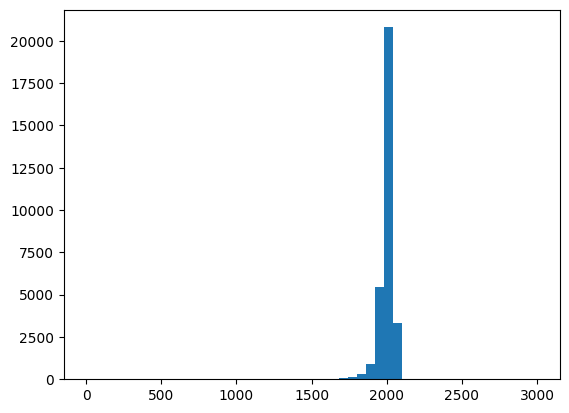

In [85]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

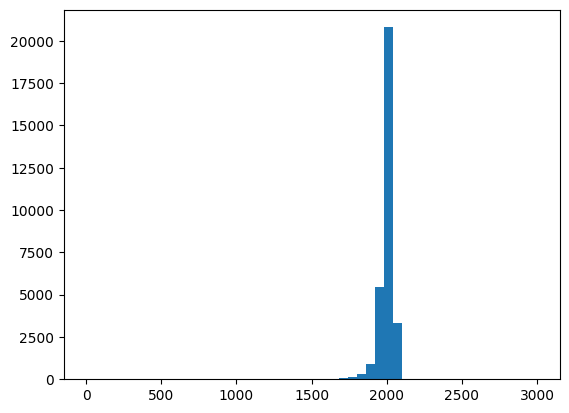

In [89]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

In [108]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

"Full text is available to Purdue University faculty, staff, and students on campus through this site.\nOff-campus Purdue users may download theses and dissertations by logging into the Libraries' proxy server with your Purdue Career Account.\nLinks to log in to the proxy server directly below the download button of each thesis or dissertation page.\nNon-Purdue users, may purchase copies of theses and dissertations from ProQuest or talk to your librarian about borrowing a copy through Interlibrary Loan.\n(Some titles may also be available free of charge in our Open Access Theses and Dissertations Series, so please check there first.)\nFortney, Sarah Katherine (2024) The Role of Trait and Specific Expectations in the Experience of Dysmenorrhea\nAbdullah, Umm E. Hani (2023) Exploratory Study of Deep Brain Stimulation in the Syngap1+/- Mouse Model of Autism Spectrum Disorder Using Electrophysiology\nAbney, Douglas John (2023) Broadband’s Role in Agricultural Job Postings In U.S. Counties\

In [110]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [90]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [112]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the comp

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board.
Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida.
The company is only paying a small amount to the council for the millions of litres it can take.
Sto

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest
Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system.
But she was also welcomed into a New Zealand export compa

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri.
In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.odt.co.nz/business/nz-milk-fetches-big-bucks-china**

You are not permitted to download, save or email this image. Visit image gallery to purchase the image.
But the high-price reflects a more complicated supply chain - and the degree to which the high-quality product is sought after in China.
It's just one o

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

## 📐 Max. Marginal relevance


In [92]:
%pip install --upgrade --quiet  rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/ullriher/venvs/averitec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [108]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=1500
)
chunks_pruned = retriever.invoke(claim)

In [109]:
len(chunks_pruned)

1500

In [110]:
chroma = Chroma(f"dev_{CLAIM_ID}_mxbai", persist_directory=f"data_store/vector_store_dev/{CLAIM_ID}")
chroma.delete_collection()
documents_ = [doc.copy() for doc in chunks_pruned]
for doc in documents_:
    if 'sentences' in doc.metadata:
        doc.metadata.pop("sentences", None)
    
chroma = chroma.from_documents(documents_, embeddings)


In [106]:
# make or overwrite /home/ullriher/aic_averitec/data_store/vector_store_dev/CLAIM_ID and persist chroma there
!mkdir -p /home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}
chroma(f"/home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'Chroma' object has no attribute 'persist'

In [114]:
claim

'New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.'

In [120]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(chunks_pruned, embeddings)
db.save_local(f"data_store/vector_store_dev/{CLAIM_ID}")

In [118]:
results = db.similarity_search(claim, 10)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get information in August last year and worked on it further last month. Mr Key said the Cabinet Office did not believe Ms Collins' had endorsed the products. "The fact the company might write down something, that happens all the time. I go to lots of things where I hold up things or say oh I use your toilet paper or whatever it might be, that's not deemed to be an endorsement." Under Parliamentary privilege, he said the situation had echoes of former National MP Pansy Wong who resigned over allegations her husband had used Parliamentary travel perks to fly to China and did business while there - which was against the rules for the use of the perks. Ms Collins said her husband had accompanied her while on an official trip to China in 2012 but had paid for himself and was on holiday. Mr Roberston said Ms Collins had opened the Auckland office of Oravida in 2013 and Oravida donated more than $55,000 to National in 2011. He said National Party president Peter Goodfellow had met with its representatives and was also part owner of Sanfords which supplied fish products to Oravida. "So knowing all of that, Judith Collins goes to this office and promotes the products of that company. That is a conflict of interest. Judith Collins is not above the rules." * Judith Collins visited Oravida in China last year. Her husband is a director. A photo of Collins was put on its website with a caption saying she endorsed its products. It is against Cabinet rules to endorse products, or do anything from which a family member may benefit. 

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Oravida, and is allegedly involved in exporting raw swamp kauri?” One of the directors of Oravida is National MP Judith Collins’ husband, David Wong-Tung. Under further questioning in the House, Minister Nick Smith replied, “I thought the member (Kelvin Davis) was above getting involved in this kind of murk”. Winston Peters then asked Dr Smith,: “Is he denying what is well known in Northland because people who are high up in Oravida are major donors to the National Party?” Dr Smith replied that the law had been changed under Labour in 2004. He says there have been prosecutions under the Resource Management Act in the past and the Ministry for the Environment and Northland councils are confident the resource is being “responsibly managed”. wealthy donors using bribery to buy ethnic list seats in Parliament … All have strong common connections … Chinese influence (business interests and CCP) and Natz! Only a few reasons crass, uncaring, disrespectful, environment abuser Judith Collins should not be allowed near leading any political party! And yet she will take power in 2020, unless foreign colonists with voting rights are sent packing (how many Natzi voters are “we” importing on a daily basis?)… Your use of the word Natzi is disgraceful, reconsider. I would never vote for Collins, she is an absolute muppet and wants power far too much. Even though I wouldnt vote for Collins, doesn’t mean I would ever vote for Cindy, gave her the benefit of the doubt but she’s proving to be a creepy socialist through and through…. We need a third option, a proper conservative govt that doesn’t put the dole bludgers and economic ‘refugees’ before our hard working people. And your use of the name “Cindy” is disgraceful, reconsider or you will have the label HYPOCRITE! 

**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China. One News reported that while Ms Collins was in China last October she visited the offices of Oravida, a New Zealand company which exports milk products to China. Her husband, David Wong Tung, is a director of Oravida and the company later put up a photo of Ms Collins claiming she had tasted and endorsed their products. It is against Cabinet Manual rules to endorse any product. Labour MP Grant Robertson said there was a perception of a conflict of interest. "Ministers have to be up front. Perception matters.'' Ms Collins said she was not aware of the photo and would ask for it to be removed if it breached Cabinet guidelines. "I certainly don't endorse any products other than the fact I always try and help New Zealand companies trying to export.'' Prime Minister John Key said he did not believe Ms Collins' husband's directorship of Oravida created a conflict of interest. "It doesn't preclude her dropping in. There is no commercial value there.'' 

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board. Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp kauri to Oravida when he found them and was not charged by Oravida for the digger. …Oravida, how extraordinary. Let’s remind ourselves about Oravida again… October 2013 – Judith Collins opens Oravida’s new Auckland headquarters. October 20, 2013 – Collins has dinner with Oravida bosses Stone Shi and Julia Xu, along with a senior Chinese border official in Beijing, China, while on a tax-funded trip. She claims it was a “personal dinner” and that no business was discussed. October 23, 2014 – Collins visits Oravida’s Shanghai offices “on the way to the airport”. December 23, 2013 – Oravida makes a $30,000 donation to the National Party. March 4, 2014 – Collins denies dinner was a conflict of interest. March 12, 2014 – Collins admits she had dinner with Oravida bosses, but calls suggestions she should resign “ridiculous”. She is put on her last warning by Prime Minister John Key. March 18, 2014 – Despite Collins’ claims she visited the Oravida offices in Shanghai “for a cup of tea on the way to the airport”, it is revealed the company’s offices are 30km in the opposite direction. April 15, 2014 – 3 News reveals Oravida requested help from the Government on Chinese border control issues just weeks before Collins’ dinner. April 17, 2014 – Winston Peters alleges the Chinese official present at the Beijing dinner represented the agency that decides whether imported food products are safe. May 2, 2014 – There are calls for Collins to resign, following the resignation of MP Maurice Williamson for interfering in a police case involving wealthy Chinese businessman Dongua Liu. 

**https://www.reddit.com/r/newzealand/comments/f50ujj/rnz_solved_mysteries_oravida_the_gas_line_and_the/**

In July 2015, parliamentary privilege was used to link the export of swamp kauri to Northland and National Party donors and insiders. In Parliament, Labour's MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were "aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Oravida, and is allegedly involved in exporting raw swamp kauri?" One of the directors of Oravida is National MP Judith Collins' husband, David Wong-Tung. The argument is that Oravida is exporting them to China under the guise of being tables and the money is being funneled into their political affiliations which just happen to include the political party Wong-Tung's wife (Judith Collins) is a prominent member of: National. This was of course denied, and RNZ even [had to write an apology to Oravida] (https://www.rnz.co.nz/news/national/276363/minister-defends-trade-in-kauri-swamp-logs) at the bottom of their article, saying that they were wrong to suggest Oravida were involved in the export of illegal swamp kauri. FYI.org.nz reports that the OIA request for Judith Collins to speak to her involvement was denied. You can follow the link to see the fuckery used to avoid fulfilling the request. However, when piecing together the company's purpose as Oravida Kauri Ltd, the people involved, and the history of questionable exports, it's quite clear that a proper investigation should have been done and putting it on the shoulders of the contractor seems unfair at best. And then there's Collin's connection as a National MP, her relationship with Oravida, and the donations and connections the company and the party have formed. In September 2017, a digger damaged part of a 168km jet-fuel line which caused tens of millions of dollars in lost business and repairs, grounded dozens of flights and caused havoc on the supply chain. 

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border official and leaders of dairy export company Oravida, which her husband was director of. Collins later said she regretted the visit and that her husband had not financially benefited as he was the director, not a shareholder. In 2016 when John Key resigned as National leader, Collins stood as a candidate, but Bill English became the leader. Then in 2018 when Bill English resigned as leader, Collins again entered the race, but Simon Bridges won the leadership. During Bridges’ reign, a poll ranked her higher as the preferred prime minister above Simon Bridges, even though she wasn’t even in the running to be PM at the time. 

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the company. Labour's Grant Robertson continued to claim Collins breached conflict of interest rules for ministers for the visit to Oravida, despite Prime Minister John Key saying the Cabinet Office had advised there was no breach. Ms Collins' husband is a director of the New Zealand milk product exporting company and after her visit, the company put a photo of her on its website and said she had tasted and endorsed its products. The Cabinet Manual prohibits Ministers endorsing products. It also says a perception of a conflict of interest may arise where a family member or friend of a minister could get some benefit from the ministers' actions or decisions. Ms Collins said she had told Oravida in advance that it could not use her name or photograph to endorse or promote its products and had not known about the photo on the website. She had since asked Oravida to ensure it was not claiming she endorsed it, in either English or mandarin. She had tasted the milk and said "it was nice" but that did not amount to an endorsement of the company. "Shock, horror, I drink milk. I promote New Zealand milk anywhere I go. It's the finest milk in the world." She said Mr Robertson's claims were "desperate" and solely because he was trying to help Labour leader David Cunliffe escape scrutiny for his use of trusts. However, Mr Robertson claimed there was still a clear conflict of interest. "Going to a company where her husband is a director, having a photo taken and being said to have endorsed the products fits within that conflict." Mr Robertson denied he had timed the allegations to detract attention from Mr Cunliffe's campaign funding. 

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system. But she was also welcomed into a New Zealand export company that her husband has a private interest in. She says the purpose of her visit was “to actually have a cup of tea on the way to the airport”. Ms Collins’ husband, David Wong-Tung, is one of three directors of Oravida – a milk and food export company. On its website the company referred to her as the Justice Minister. It says she recognised the company’s efforts, and “congratulated us on what we have achieved and encouraged us to continue”. Ms Collins also opened the company’s Auckland headquarters last year, with Mr Wong-Tung standing behind her. She says it is not an issue that she was effectively promoting the company where her husband is a director. Why isn’t this getting as much coverage as Cunliffe’s supposed betrayal of democracy? Judith Collins can’t wave her connection with her husbands company around much more than adding her name and posting photos with a promotional gulp of milk to support the product. “a conflict may arise if people close to a minister, such as a minister’s family […] might derive, or be perceived as deriving, some personal, financial, or other benefit from a decision or action by the minister”. “When accepting an invitation, a minister should inform the organisation that it may not use any photos taken of the minister at the event in a way that could be perceived as an endorsement by the minister.” There’s not really much wriggle room here is there? Nothing highlights the double standards within the media better than the difference in exposure between Cunliffe’s sins and what seems to be a Judith’s massive conflict of interest. I think why there is no coverage is the age old media bias by the owners of the sensationalism carnival – no mystery really. Will she be crushed by the weight of her own ego ? I hope so… 

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida. The company is only paying a small amount to the council for the millions of litres it can take. Stone Shi and Julia Xu are the brains behind Oravida, and part of Prime Minister John Key's delegation in Beijing. They're now exporting Kiwi water to China as a premium product. "It has been filtered for many many years, and through the filtration process it carries a lot of great minerals for bodies," Ms Xu says. The pair's close personal ties to Judith Collins caused a huge political controversy in 2014. They've now expanded from Scampi and milk, to water from a plant in the Bay of Plenty it bought for an undisclosed sum last year. Oravida has a consent to 146 million litres of ground water a year and the regional council says Oravida pays an annual compliance charge of around $500. Oravida markets the water at $1.60 a litre, meaning if all 146 million litres were sold it could be worth $233 million a year. "The right to draw water is determined by the local council," Ms Xu says. The Prime Minister says water could be the next big thing, saying the market is "potentially huge". It's huge because of New Zealand's clean, green image, which Oravida is using as a key selling point. 

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up to 400,000 litres of water a day from the Otakiri Aquifer in Bay of Plenty. This will allow the company to take up to 146 million litres a year from the aquifer until 2026. An Bay of Plenty Regional Council spokesperson said Oravida had paid a total $1503 for the consents since 1992, and last year paid $526 in compliance costs. "The Resource Management Act 1991 only allows the Regional Council to recover actual and reasonable costs associated with processing and managing resource consent applications to take water," she said. Massey University freshwater ecologist Mike Joy said the same thing will keep happening until the government charged for water. "It's just a free for all for a tiny proportion of New Zealanders, that abuse something that belongs to all of us. Whether they be farmers polluting the water, or taking it out for irrigation, or if it's bottling companies taking it away, the core issue is that we are not putting a price on it." Mr Joy said charging users would dramatically improve how efficiently water was used. Greens water issues spokesperson Catherine Delahunty said it was wrong for companies like Oravida to make a profit by exporting this increasingly valuable resource. "This is happening not only in the Bay of Plenty but all over the country. There's 74 bottling plants. But, when the water is purely for export it means we're giving away that water for nothing, when we may need it in the future." Hundreds of people marched in Ashburton on Saturday, protesting against the council there selling off a piece of land with the right to extract 45 litres of water a second from the town's aquifers for the next 30 years. 

In [119]:
results = db.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri. The above quote was when Judith was challenged that Oravida was damaging the environment. What a sad day for Judith, appar

**https://www.newsroom.co.nz/wong-tung-threatens-to-sue-newsroom**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://fyi.org.nz/request/6595-involvement-of-kauri-ruakaka-limited-in-the-oil-pipeline-rupture-between-whangarei-and-auckland**

Involvement of KAURI RUAKAKA LIMITED in the oil pipeline rupture between Whangarei and Auckland Reuben Tilley made this Official Information request to Minister of Energy and Resources The request was refused by Minister of Energy and Resources. Can you pl

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.parliament.nz/en/pb/hansard-debates/rhr/document/51HansD_20141104_00000012/organised-crime-and-anti-corruption-legislation-bill**

Judith Collins introduced this legislation to Parliament. The irony of that is that Judith Collins introduced this legislation around the time that she took a trip to China to talk about reducing corruption, and yet she was surreptitiously visiting Oravida

In [112]:
results = chroma.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Orav

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri. In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://newsroom.co.nz/2020/08/10/wong-tung-threatens-to-sue-newsroom/**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

## ❌ Cross-encoder re-ranking 

In [100]:
# Load the model, here we use our base sized model
model_name = "mixedbread-ai/mxbai-rerank-large-v1"
model = CrossEncoder(model_name)

# Example query and document

# Lets get the scores
results = model.rank(claim, [doc.page_content for doc in chunks_pruned], return_documents=True, top_k=10)


display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-rerank-large-v1*



**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politi

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general el

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus sto

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National le

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the fi

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ar

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught wit

In [101]:
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime ministers, Jacinda Ardern. In many ways, the two could not be more different. Margaret Thatcher is Collins’ political hero. “I like the fact she didn’t give up when others would have. She didn’t give in to what other people thought she should do, or be.” Collins, 61, is a famously tough, take-no-prisoners party stalwart, nicknamed “Crusher Collins” for her desire to destroy the cherished cars of boy racers. She is also famed for her tough stance on crime, supported the introduction of Tasers to the police force, and argued for officers to have better access to firearms. But there is another side. She is one of the more socially liberal National leaders in recent years, she loathes “all forms of racism and sexism”, voted for the legalisation of same-sex marriage, taking abortion out of the Crimes Act, and legalising euthanasia. She is also an animal tragic who is still grieving the loss of her dog, Holly, euthanised while the country was under effective house-arrest. The leadership of the centre-right National party has eluded Collins for years, despite her evident penchant and suitability for a leadership role. On Tuesday – when Todd Muller unexpectedly resigned after 53 days citing health reasons – Collins claimed the top job, saying the party had decided her “strength and decisiveness” were what the party needed so close to an election and after a slew of high-profile resignations. Collins may also be the party’s only hope against the staggering popularity of Ardern. The daughter of Waikato dairy farmers, Collins has long been a decisive political figure in New Zealand’s otherwise somewhat beige parliament, and in her 18 years in the beehive – as the parliamentary building is known – she has never been far from the action. 

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politicians in the right-of-centre party saying he was stepping down "effective immediately." The 67-year-old former business executive had led the party for only 53 days, toppling previous leader Simon Bridges in a leadership coup amid National's stagnant polling numbers. Ms Collins was chosen to take over the leadership in a hastily arranged meeting of the party's parliamentary caucus in Wellington on Tuesday evening. She is National's fourth leader in three years and its second female leader. Ms Collins was first elected to Parliament in 2002, serving in governments under prime ministers John Key and Bill English. She held police and corrections portfolios and is seen to represent the right-wing of the National Party, having previously promoted strong law and order policies. Ms Collins now faces the task of trying to rally National's support 67 days from 19 September elections at which it will try to unseat the governing Labour Party of popular Prime Minister Jacinda Ardern. Judith Collins (right) with new deputy leader Gerry Brownlee (left) at New Zealand Parliament in Wellington. Recent polls show Labour with sufficient support to form a majority government, a first since New Zealand adopted a system of proportional representation in 1996. All previous governments since that time have been coalitions and Labour currently governs with the support of the Green Party and right-of-centre New Zealand First led by Winston Peters. Mr Muller's sudden departure forced a scramble of lawmakers to Wellington during a parliamentary recess. Mr Muller said his health made his continuation in the leadership untenable. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and corrections, of impounding and crushing the cars of so-called “boy racers”, earning her the nickname “Crusher Collins” – which is still widely used. Other than Ardern she is one of the few New Zealand lawmakers whose first name alone would spark recognition with the public. Ben Thomas, a centre-right commentator, said that made her the party’s only choice. “She’s the only person in National who is assured enough and polished enough to foot it with Jacinda Ardern,” he said. Thomas added that the “patricians” of the party had been unable to “go head to head” with the prime minister, who often answers the public’s questions in Facebook Live broadcasts from home and had a 54% preferred prime minister rating in a June poll (her then-rival, Muller, held 13% support). Collins’s rise came at the end of a horror day for National; its lawmakers had been unaware of what was coming when their leader suddenly announced his resignation, “effective immediately” by email on Tuesday morning, saying in a statement that his leadership was “untenable from a health perspective” and had “taken a heavy toll” on him personally. “It has become clear to me that I am not the best person to be leader of the opposition and leader of the New Zealand National party at this critical time for New Zealand,” said Muller. “It is more important than ever that the New Zealand National party has a leader who is comfortable in the role.” He has made no further comment, has not appeared in public since his resignation, and did not attend Tuesday’s meeting to select his replacement. In June, shortly after Muller assumed the leadership after ousting his predecessor, National had risen in the polls to just 38% against Labour’s 50% – meaning Ardern’s party could govern alone. 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is a clear-sighted defender of the neoliberal order who is prepared to give when she needs to give, and takes no prisoners when she doesn’t. Collins is articulate, shrewd and possesses a disarming (if somewhat cruel) sense of humour. Those on the left who dismiss her as a major electoral turn-off will, almost certainly, be proved wrong. She has what it takes to manoeuvre Jacinda and Labour onto the defensive. And, as everybody knows: explaining is losing. Like Act’s current collection of strategists, Collins understands that delivering neoliberalism straight leaves voters with a sour taste in their mouths. It goes down much better when fizzed-up with lashings of law-and-order rhetoric – along with generous splashes of “culture wars” liqueur. That Collins, herself, happily owns up to being a “social liberal”, only adds an extra kick to her political cocktail. It’s this political ambiguity that makes National’s new leader so dangerous. Collins does not belong to the crazy Christian Right faction of her caucus, but neither is she a member of the Nikki Kaye, Amy Adams, Chris Bishop “soppy liberal” wing of the party. (Although she may, from time-to-time, be found voting alongside them.) For a long while now this ambiguity has constituted an unhelpful obstacle to her advancement. With the right rejecting her as too left, and the left dismissing her as too right, she has fallen repeatedly between the two stools. But now, with both factions severely discredited, being a little bit country and a little bit rock-n-roll has proved to be no bad thing at all. When pitted against Jacinda, however, it’s Collins’ neoliberalism which is likely to prove most deadly. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general election in September following a leadership vote in the centre-right National party. Collins, who has long held leadership ambitions but whose party is floundering in the polls, will face an uphill battle to persuade voters away from Ardern, one of the most popular New Zealand prime ministers of all time. Her centre-left Labour party is riding high in the polls after Ardern’s government quashed the spread of Covid-19 in the country, with many regarding the prime minister as something of a saviour figure. While Collins’s predecessor had said he would not oppose the government “for opposition’s sake,” her ascension sets the stage for a clash of ideologies on the campaign trail: the 61-year-old politician, who has decried the “woke left”, said in May that she was “sick of being demonised” for being white. “I think it’s important that we give credit where it’s due,” she said of Ardern at a news conference after she won a late-night vote on Tuesday. But there was “no chance at all that I’m going to let Jacinda Ardern get away with any nonsense”. The new party leader was staunch when she took the podium, surrounded by her MPs, after National held a late-night, closed-door vote at New Zealand’s parliament in Wellington, following the shock resignation on Tuesday morning of Todd Muller. He quit abruptly after leading the party for a volatile 53 days – the shortest stint in its history – characterised by leaks, distractions, weak interview performances, and rogue MPs. He had ousted the previous leader, Simon Bridges in a coup in May after dismal polling showed a heavy loss for the party in September. 

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus stood alongside Collins and Brownlee as they addressed media. "Third time lucky," Collins said, referring to the other leadership bids she's made. She said Paul Goldsmith would remain National's finance spokesperson, but couldn't confirm whether Michael Woodhouse would remain health spokesperson. “I don’t see major shifts at all in the policies we have," she said, stressing there wouldn’t be “wholesale” policy changes. Collins said the caucus decision not to work with New Zealand First still stood. “I think we need to be very focussed on just sticking to focussing on our party vote, and understanding there are other players coming into politics at this time as well,” she said. While Muller, and his former deputy Nikki Kaye in particular, were well-placed to target centrist voters, Collins said: “I think it is important that we send some very strong messages out to our base voters, who have been, obviously, a bit discombobulated with the last day or so. They need to know that we’re absolutely back on track and we will be taking the fight to the Government.” Asked whether she would adopt the same approach Muller said he would - to not be in “opposition for opposition’s sake”, Collins responded: “I think it’s important that we give credit where it’s due, but at the same time there is no chance at all that I’m going to let Prime Minister Jacinda Ardern get away with any nonsense when it comes to our economy and doing her job. Collins described herself as a "provincial Aucklander", saying her strengths were her toughness, experience and ability to make decisions. “I am hoping the National Party will collectively crush the other lot,” she said. 

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National leader Judith Collins delivered the opposition's infrastructure plan - a policy former leader Todd Muller was meant to make before quitting on Tuesday. Collins has also announced a National government would repeal the Resource Management Act completely, and replace it with two new pieces of law. More than half of the money announced by Collins today ($17b) would be invested in the upper north, which Collins said was home to half of all New Zealanders. To fix the congestion issues, Collins announced "National would go ahead with everything Labour has said it will do in transport" - with the exception of Transport Minister Phil Twyford's "light-rail Ghost Trains, and the probable exception of the $360 million Skypath 2". She said National would also go much further, with some work beginning immediately and the larger projects rolled out over the next decade. One of the most ambitious projects announced was four-lane expressways - including tunnels under the Brynderwyn and Kaimai mountain ranges - to connect Whangārei, Auckland, Hamilton and Tauranga. "National's vision is to transform the four cities to be one economic powerhouse, unlocking their potential so the upper North Island becomes Australasia's most dynamic region,'' Collins said. Also part of the announcement is Auckland's rapid transit network, including rail to the airport and new busways. "One rough definition of a city is that it is a place you can get from one side to the other in an hour, or a place that the average time to get to work is 30 minutes. National will measure our progress against the goals of 30 minutes to get to work and one hour to get across the city,'' Collins said. 

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the first exchange in the house I caught between Collins and P.M. Ardern invites the comparison in the pugnacious political style the new Opposition Leader is projecting. There is also more than an element of the “Think Big “ project of the Muldoon era in Collins’ plan to bypass the Resource Management Act for huge infrastructure projects such as the proposed four-lane highway from Whangarei to Tauranga and a second Auckland harbour crossing. The idea that you just bulldoze any legislation designed to protect our environment out of the way in the name “progress” is very Muldoon at his draconian worst. Most Acts of Parliament require review from time to time and the RMA is no exception . Moreover, in my view, Transport is certainly one of those areas where Labour is weakest and therefore most vulnerable to attack from the Right. It does seem to me however, as we watch the issue of traffic congestion especially in Auckland and Wellington being debated in the run up to the election, that we need to think about whether more cars on our roads (be they petrol driven or electric) is really such a great idea. Or whether a radical rethink about how we get from A to B – eg. completely free, highly efficient bus, light rail and train services – is in order As for Muldoon. I interviewed him on two occasions. He was a highly divisive politician who rolled the job of Finance Minister into that of the Prime Minister and became drunk on power. But, he was something Judith Collins and her current National Party colleagues are not. He was anti-neoliberal. He rejected Treasury’s advice to follow the economic path of self-centeredness being advocated by Britain’s then Conservative Prime Minister Margaret Thatcher and Republican President Ronald Regan. 

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ardern’s popularity demonstrates. A leader of the Opposition who was able to mix it in a roughhouse could still be seen as lacking the poise and judgment that would be needed in a Prime Minister. We should never forget that what makes the job of leading the Opposition so difficult is that the holder of that office must be seen not only as an effective and combative critic of the government but also as a potential Prime Minister. It is here that the case for a Judith Collins leadership really starts to crumble. We now know enough about her to doubt whether she is an appropriate, let alone credible, candidate for the top job. A simple rehearsal of some of the high (or perhaps that should be low) points of her political career should be enough to confirm those doubts. Her close relationship with Cameron Slater – he of “Dirty Politics” fame – should ring the alarm bells; Cameron Slater regards her as his mentor in the black arts and has said as much. Her refusal to recognise the conflict of interest implicit in a dinner with her husband’s firm, Oravida, when on a taxpayer-paid ministerial visit to China was compounded by the misinformation she offered to explain the visit she paid to its offices – it was, she said, simply for a “cup of tea on the way to the airport”, when the airport was actually in the opposite direction. These malfeasances obliged both the Speaker and John Key, when Prime Minister, to reprimand her and stand her down. These elements strongly suggest that what might be seen by her supporters as a commendable willingness to cut corners and to “get down and dirty” should actually disqualify her from offering herself as a potential Prime Minister. 

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught with resignations, troublesome tweets and Dirty Politics. But she's arrived now, and believes there are no skeletons left in the closet. "If anyone's gone through having all their emails gone through, all their phone records and everything else for years… I think we're perfectly fine," she told Magic Talk on Wednesday. "If someone wants to try something, fine. I'm ready for them. I'm focused on the people of New Zealand, I'm not worrying about the sort of muckrakers we've dealt with in the past." Need a reminder of what Collins has dished up in the past? Below are the biggest controversies of her political career. Judith Collins was accused in 2014 of a conflict of interest with Oravida bosses - a company where her husband was a director - and a Chinese official. During a taxpayer-funded visit to China in her role as Justice Minister in 2013, Collins was welcomed into the New Zealand export company and endorsed the milk it produced. Prime Minister John Key criticised the visit, causing Collins to apologise. However she said the Chinese official - who she refused to name - was a "very close personal friend". She also claimed it was "not necessarily true" that her husband would benefit financially from the company doing well, as he wasn't a shareholder. Key told media Collins was on her final warning over the incident - but she maintained she had Key's permission to meet with the company. Also in 2014, Collins found herself embroiled in the scandal sparked by Nicky Hager's Dirty Politics - an explosive book that had an entire chapter devoted to her alleged unscrupulous tactics. 